# Análise de Mídias Sociais: Twitter

Para autenticar no twitter, temos que criar uma conta e accessar: <br />
http://twitter.com/apps/new <br />
Gerar as chaves de autenticação, ex:<br />
CONSUMER_KEY = 'DcPtlOYZ07jilc3PgYJLUPdfdfdRjJXXXXX' <br />
CONSUMER_SECRET = 'bREXzcIMNLKhRpOhQGFuEKTaJhRhHcdfdfdjD3dKBe682Yt2MOiNv6bXXXX' <br />
OAUTH_TOKEN = '2904474861-coE0I5LEq8btCC0A18IPjqOp1G24dfdfdfvBgwXKyPi5bXXXX' <br />
OAUTH_TOKEN_SECRET = 'ppDRYIeSXOb6J6qajqXolniwVNgbAkIEdfdfdfYDS9VfIzOboQoXXXX'<br />

## Modulo para autenticação no twitter

In [1]:
#!pip install twitter
#!pip install pymongo

In [2]:
!cat tokens.txt

DcPtlOYZ07jilc3PgYJLUPRjJ
bREXzcIMNLKhRpOhQGFuEKTaJhRhHcjD3dKBe682Yt2MOiNv6b
2904474861-qPmMjcwisBQWR1cMILoXevC8QeKS3Go3PzN5lBq
h0iaWqpk7YqsP9MAk5mU472ZOsFOtunfL76fwhEY3x9PA

## Leitura das chaves de acesso

In [1]:
def ler_tokens_acesso():
    filename = 'tokens.txt'
    with open(filename) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content] 
    
    return content[0], content[1], content[2], content[3]

#CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET = ler_tokens_acesso()
#print(CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET)

# Twitter

In [3]:
import twitter

def oauth_login():
    # XXX: Go to http://twitter.com/apps/new to create an app and get values
    # for these credentials that you'll need to provide in place of these
    # empty string values that are defined as placeholders.
    # See https://dev.twitter.com/docs/auth/oauth for more information 
    # on Twitter's OAuth implementation.
    
    #CONSUMER_KEY = 'DcPtlOYZ07jilc3PgYJLUdfdfdfJ'
    #CONSUMER_SECRET = 'bREXzcIMNLKhRpOhQGFuEKTaJhRhHcjD3dKBe682Yt2MOdfdf'
    
    #OAUTH_TOKEN = '2904474861-hJHuW0Q1TGSUjOFvlgqU4ZFYvPCDO214aILxR5L'
   # OAUTH_TOKEN_SECRET = 'aBCJrbhXVEBgZ7gKo9yCNUMjlierefMkY43rZEvXK9BFI'
    
    CONSUMER_KEY, CONSUMER_SECRET, OAUTH_TOKEN, OAUTH_TOKEN_SECRET = ler_tokens_acesso()
    
    auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,
                               CONSUMER_KEY, CONSUMER_SECRET)
    
    twitter_api = twitter.Twitter(auth=auth)
    return twitter_api

# Sample usage
twitter_api = oauth_login()    

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print (twitter_api)

## Módulo para buscar tweets, dado uma palavra

In [4]:
def twitter_search(twitter_api, q, max_results=1000, **kw):  #max_results=200

    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets and 
    # https://dev.twitter.com/docs/using-search for details on advanced 
    # search criteria that may be useful for keyword arguments
    
    # See https://dev.twitter.com/docs/api/1.1/get/search/tweets    
    search_results = twitter_api.search.tweets(q=q, count=1000, **kw)   # count=100
    
    statuses = search_results['statuses']
    
    # Iterate through batches of results by following the cursor until we
    # reach the desired number of results, keeping in mind that OAuth users
    # can "only" make 180 search queries per 15-minute interval. See
    # https://dev.twitter.com/docs/rate-limiting/1.1/limits
    # for details. A reasonable number of results is ~1000, although
    # that number of results may not exist for all queries.
    
    # Enforce a reasonable limit
    max_results = min(1000, max_results)
    
    for _ in range(10): # 10*100 = 1000
        try:
            next_results = search_results['search_metadata']['next_results']
        except KeyError: # No more results when next_results doesn't exist
            break
            
        # Create a dictionary from next_results, which has the following form:
        # ?max_id=313519052523986943&q=NCAA&include_entities=1
        kwargs = dict([ kv.split('=') 
                        for kv in next_results[1:].split("&") ])
        
        search_results = twitter_api.search.tweets(**kwargs)
        statuses += search_results['statuses']
        
        if len(statuses) > max_results: 
            break
            
    return statuses

## Salvando/Recuperando no MongoDB

In [5]:
import json
import pymongo # pip install pymongo


def save_to_mongo(data, mongo_db, mongo_db_coll, **mongo_conn_kw):
    
    # Connects to the MongoDB server running on 
    # localhost:27017 by default
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    
    # Get a reference to a particular database
    
    db = client[mongo_db]
    
    # Reference a particular collection in the database
    
    coll = db[mongo_db_coll]
    
    # Perform a bulk insert and  return the IDs
    
    return coll.insert_many(data)

def load_from_mongo(mongo_db, mongo_db_coll, return_cursor=False,
                    criteria=None, projection=None, **mongo_conn_kw):
    
    # Optionally, use criteria and projection to limit the data that is 
    # returned as documented in 
    # http://docs.mongodb.org/manual/reference/method/db.collection.find/
    
    # Consider leveraging MongoDB's aggregations framework for more 
    # sophisticated queries.
    
    client = pymongo.MongoClient(**mongo_conn_kw)
    db = client[mongo_db]
    coll = db[mongo_db_coll]
    
    if criteria is None:
        criteria = {}
    
    if projection is None:
        cursor = coll.find(criteria)
    else:
        cursor = coll.find(criteria, projection)

    # Returning a cursor is recommended for large amounts of data
    
    if return_cursor:
        return cursor
    else:
        return [ item for item in cursor ]

## Capturando tweets

In [10]:
q = 'covid19'
q = 'Tokyo2020'
result = twitter_search(twitter_api, q, max_results=5000)
type(result)

list

In [11]:
result[0]

{'created_at': 'Tue Aug 03 22:03:50 +0000 2021',
 'id': 1422679631149166592,
 'id_str': '1422679631149166592',
 'text': 'RT @gorin: #スポーツクライミング  男子複合【速報】\n\n予選のスピードで楢崎智亜選手が２位と良いスタートを切りました🙌\n\n #Tokyo2020 #オリンピック https://t.co/2IZOTyy3h1',
 'truncated': False,
 'entities': {'hashtags': [{'text': 'スポーツクライミング', 'indices': [11, 22]},
   {'text': 'Tokyo2020', 'indices': [68, 78]},
   {'text': 'オリンピック', 'indices': [79, 86]}],
  'symbols': [],
  'user_mentions': [{'screen_name': 'gorin',
    'name': 'オリンピック',
    'id': 2809683683,
    'id_str': '2809683683',
    'indices': [3, 9]}],
  'urls': [],
  'media': [{'id': 1422481427573067779,
    'id_str': '1422481427573067779',
    'indices': [87, 110],
    'media_url': 'http://pbs.twimg.com/media/E72rUl4VUAMkQHp.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/E72rUl4VUAMkQHp.jpg',
    'url': 'https://t.co/2IZOTyy3h1',
    'display_url': 'pic.twitter.com/2IZOTyy3h1',
    'expanded_url': 'https://twitter.com/gorin/status/1422481660247904258

In [12]:
len(result)

1100

In [13]:
#results = twitter_search(twitter_api, q, max_results=1000)
save_to_mongo(result, 'Tokyo2020', q)

In [10]:
q = 'petrobras'
q = 'sarampo'
q = '#IveteSangaloNoTVZ'
q = '#AbortoÉCrime'
q = 'neymar'
q = 'Anitta'
q = 'Marilia mendonça'
twitter_api = oauth_login()
results = []
for i in range(1):
    result = twitter_search(twitter_api, q, max_results=1000)
    print ('capturando ', len(result),' tweets...')
    results.extend(result) # junçao de 2 lstas
    #results += result
#print(type(result))
#print(type(results))
print("Numero de tweets capturados: ", len(results))

#results = twitter_search(twitter_api, q, max_results=1000)
#save_to_mongo(results, 'tweets', q)

capturando  200  tweets...
Numero de tweets capturados:  200


In [11]:
results[2] 

{'created_at': 'Thu Oct 29 22:55:18 +0000 2020',
 'id': 1321948753956376576,
 'id_str': '1321948753956376576',
 'text': 'cês gosta do BIN só por causa da música da Marília Mendonça',
 'truncated': False,
 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []},
 'metadata': {'iso_language_code': 'pt', 'result_type': 'recent'},
 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 972813192257835008,
  'id_str': '972813192257835008',
  'name': '12/12',
  'screen_name': 'finlander97',
  'location': '',
  'description': '👇🏻 MEU ÚLTIMO SOM 👇🏻',
  'url': 'https://t.co/SzqUTUjfHd',
  'entities': {'url': {'urls': [{'url': 'https://t.co/SzqUTUjfHd',
      'expanded_url': 'https://youtu.be/a8oanY6JF78',
      'display_url': 'youtu.be/a8oanY6JF78',
   

In [12]:
results[1]['created_at']

'Thu Oct 29 22:55:23 +0000 2020'

In [13]:
results[1]['metadata']['iso_language_code']

'pt'

In [14]:
len(results)

200

## imprimindo tweets

In [15]:
#result = results
i = 0
for tweet in results:
    #print(tweet['place'], tweet['created_at'], ' >> ', tweet['text'] , " >> ", )
    print(tweet['text'])
    i += 1
    if i > 10:
          break

É bem melhor falar a verdade do que depois se arrepender.  
       - Marília Mendonça
Já dizia Marília Mendonça,pra um bom entendedor meia ausência basta 😜
cês gosta do BIN só por causa da música da Marília Mendonça
marília mendonça tem uma música com a data do meu aniversário ☺️☺️
RT @MatheusComunica: IBOPE - RECIFE

João Campos (PSB): 31% (+2)

Marília Arraes (PT): 18% (+4)

Patrícia Domingos (Podemos): 16% (+3)

Men…
Ibope sempre ajusta na reta final. Resultado: Mendonça derrete e Marília cresce https://t.co/3ffbwd9HnA
RT @blogdejamildo: João Campos lidera em rejeição, seguido por Mendonça, Feitosa, Marília e Patrícia Domingos
https://t.co/SZYfbenvWQ https…
RT @josetomazfilho: Pesquisa Ibope no Recife: João Campos, 31%; Marília Arraes, 18%; Delegada Patrícia, 16%; Mendonça Filho, 13%  https://t…
Pesquisa Ibope no Recife: João Campos, 31%; Marília Arraes, 18%; Delegada Patrícia, 16%; Mendonça Filho, 13%  https://t.co/KVsufBfLdH
@JliaBazlio1 @ValcireneA Marília Mendonça  

NÃO PREJUDI

## Nuvem de Palavras - tweet

### Stopwords

In [16]:
# instalando o módulo de stopwords
#!pip install stop-words
results = result

In [17]:
from stop_words import get_stop_words
stop_words_english = get_stop_words('en')
#stop_words
stop_words_portugues = get_stop_words('pt')
#stop_words_portugues
stop_words = stop_words_english + stop_words_portugues
print(stop_words[:10])
print(stop_words[-10:])
print(len(stop_words_english))
print(len(stop_words_portugues))

['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and']
['tém', 'tínhamos', 'um', 'uma', 'você', 'vocês', 'vos', 'à', 'às', 'éramos']
174
203


In [ ]:
#!pip install wordcloud

19065


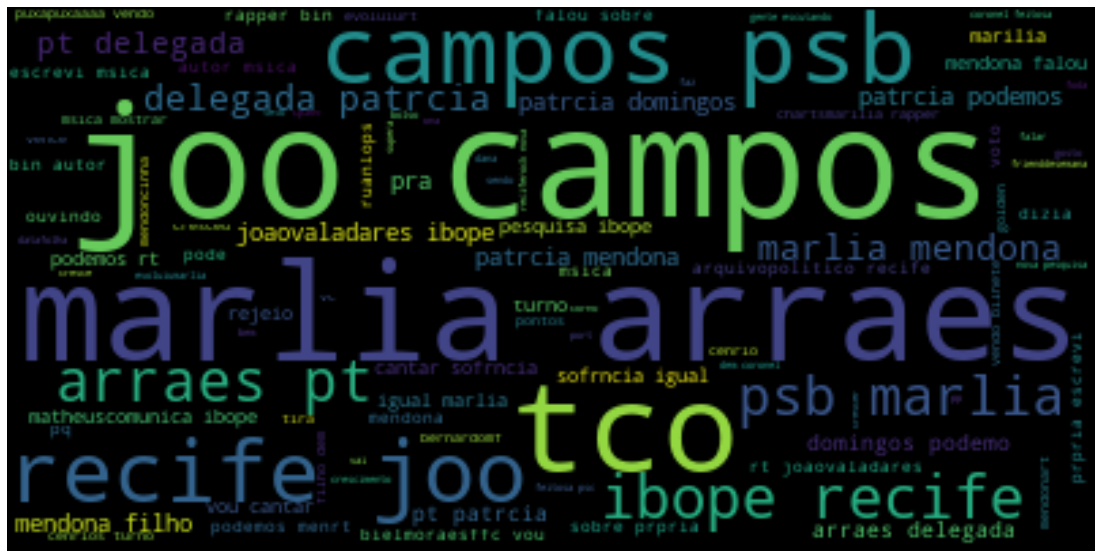

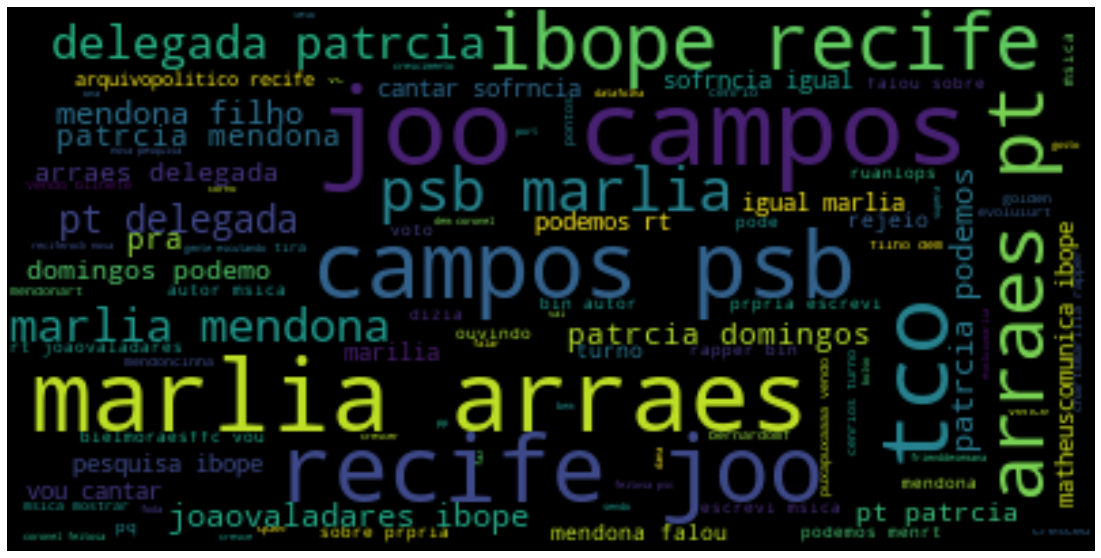

In [18]:
# nuvem de palavras
from wordcloud import WordCloud, STOPWORDS
import re

stext = ""
for tweet in result:
    if 'text' in tweet:
        stext = stext + tweet['text']
stext = stext.lower() # colocar para minúsculas

# retirando pontuações e outros caracteres não relevantes
stext = "".join([i for i in stext if ord(i)<128])
stext = stext.replace("http://","")
stext = stext.replace("https://","")
stext = stext.replace("https","")
stext = stext.replace(",","")
stext = stext.replace(".","")
stext = stext.replace("?","")
stext = stext.replace("!","")
stext = stext.replace("#","")
stext = stext.replace("@","")
stext = stext.replace("'","")
stext = stext.replace("-","")
stext = stext.replace("3","")
stext = stext.replace("&amp;","")
stext = stext.replace("|","")



# retirando as stopwords dos tweets
for word in stop_words:
    my_regex = r"\b(?=\w)" + re.escape(word) + r"\b(?!\w)"
    stext = re.sub(my_regex,"" ,stext)

print(len(stext))


# Generate a word cloud image
wordcloud = WordCloud().generate(stext)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(stext)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Estatistica de contagem de palavras

In [19]:
words = stext.split()

In [20]:
from collections import Counter

c = Counter(words)
#print (c.most_common()[:30])
most_common = c.most_common()[:40]

for i in most_common:
    print (i[0])
#for item in words:  #[words, screen_names, hashtags]:
#    c = Counter(item)
#    print (c.most_common()[:20]) # top 10
#    print 

marlia
joo
mendona
1%
campos
patrcia
ibope
arraes
18%
delegada
16%
(+4)
recife:
(psb)
(2)
(pt)
recife
joaovaladares:
(podemos)
(psb):
domingos
(+)
msica
(pt):
pra
filho
x
(podemos):
igual
sofrncia
marilia
matheuscomunica:
1%;
cantar
turno
s
pesquisa
18%;
16%;
(+2)


In [21]:
for i in range(15):
    print (c.popitem())

('outro', 1)
('sofrendo', 1)
('ganhei', 1)
('chocolate', 1)
('comendo', 1)
('(+)daqui', 1)
('tco/jioq5tzbmtrt', 1)
('(podemo', 1)
('tco/getjmuu50imatheusozado', 1)
('mendo', 1)
('tco/kj5zri2jumibope', 1)
('10)ibope', 1)
('vira', 1)
('gua', 1)
('qdo', 1)


## colocando as palavras e suas frequencias do twitter num dataframe

In [22]:
import pandas as pd
df = pd.DataFrame(([word, freq] for word, freq in most_common), columns=['Word', 'Frequency'])
df[:25]

,Word,Frequency
0,marlia,157
1,joo,103
2,mendona,101
3,1%,86
4,campos,85
5,patrcia,75
6,ibope,73
7,arraes,72
8,18%,69
9,delegada,57


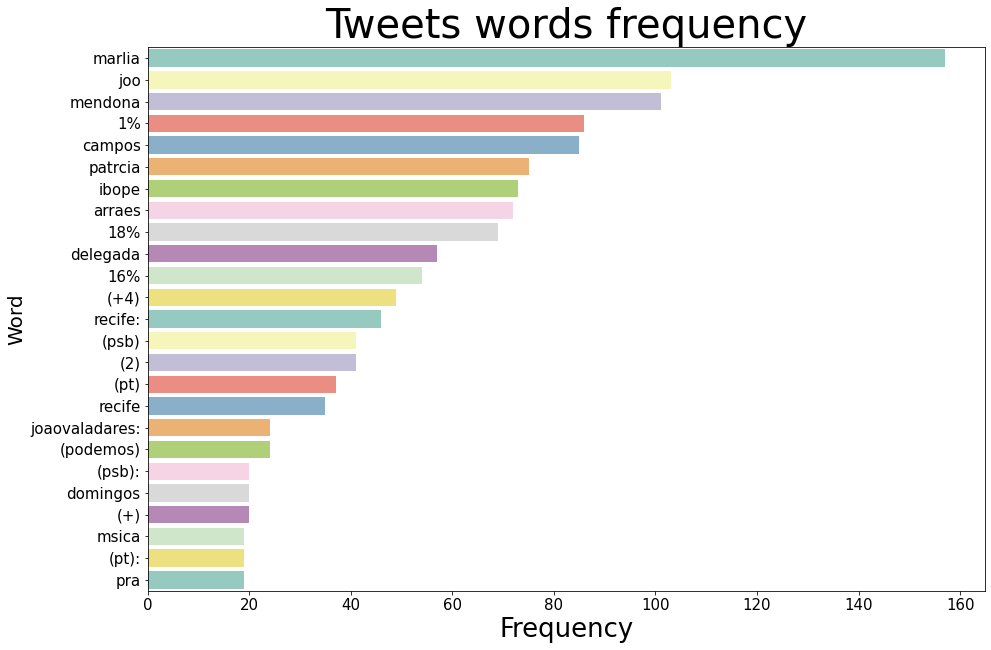

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='Word', x = 'Frequency', data=df2, palette="Set3" )
#sns.despine()
ax.set(xlabel='Tweets words frequency', ylabel='Word')
#ax.set(xticks=range(1, 9), xticklabels=list([10,20,30,40,50,60,70,80,90]))

#ax.set(xticklabels=list(range(0,90,10)))
#plt.figure(figsize=(20,10))

ax.axes.set_title("Tweets words frequency",fontsize=40)
ax.set_xlabel("Frequency",fontsize=26)
ax.set_ylabel("Word",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## achar os países de onde foram gerados os tweets

In [24]:
place = []
for result in results:
    if 'place'in result and result['place']:
        place.append(result['place']['country'])
place = set(place)
print(len(place) )
print(place)

1
{'Brazil'}


In [25]:
# cidades
place = []
for result in results:
    if 'user'  in result:
        place.append(result['user']['location'])
location = set(place)
len(location)

92

In [26]:
for i in range(15):
    print(location.pop())


🇲🇦
Jardim Sulacap, Rio de Janeiro
liarsquad 
Vila Vintém
São Luís, Brasil
Account Fan
Júlio de Castilhos, Brasil
Jaboatão dos Guararapes, PE
Salvador
Paulista, Brasil
Porto Alegre, Brasil
Neverland
olinda-pernambuco
Curitiba, Brasil


## contar a ocorrencia de cada cidade

In [27]:
from collections import Counter

c = Counter(location)
#print(c)
cidades = c.items()

## colocando as cidades, frequencia num dataframe e salvando no excel

In [28]:
import pandas as pd
df = pd.DataFrame(([cidade, freq] for cidade, freq in cidades), columns=['city', 'frequency'])

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('cidades.xlsx', engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Sheet1')

# Close the Pandas Excel writer and output the Excel file.
writer.save()
df[:15]

,city,frequency
0,he/him • pt/en,1
1,Aonde uber não entra,1
2,Recife,1
3,"Manaus, Brasil",1
4,+55021 🌴⚽️☀️,1
5,"Curitiba, Brazil",1
6,"Cidade Ocidental, Brasil",1
7,"Fortaleza, Brazil",1
8,Recife - Pe,1
9,2680/2685,1


/Users/uepb/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127796 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/uepb/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9917 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/uepb/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127796 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/uepb/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9917 missing from current font.
  font.set_text(s, 0, flags=flags)


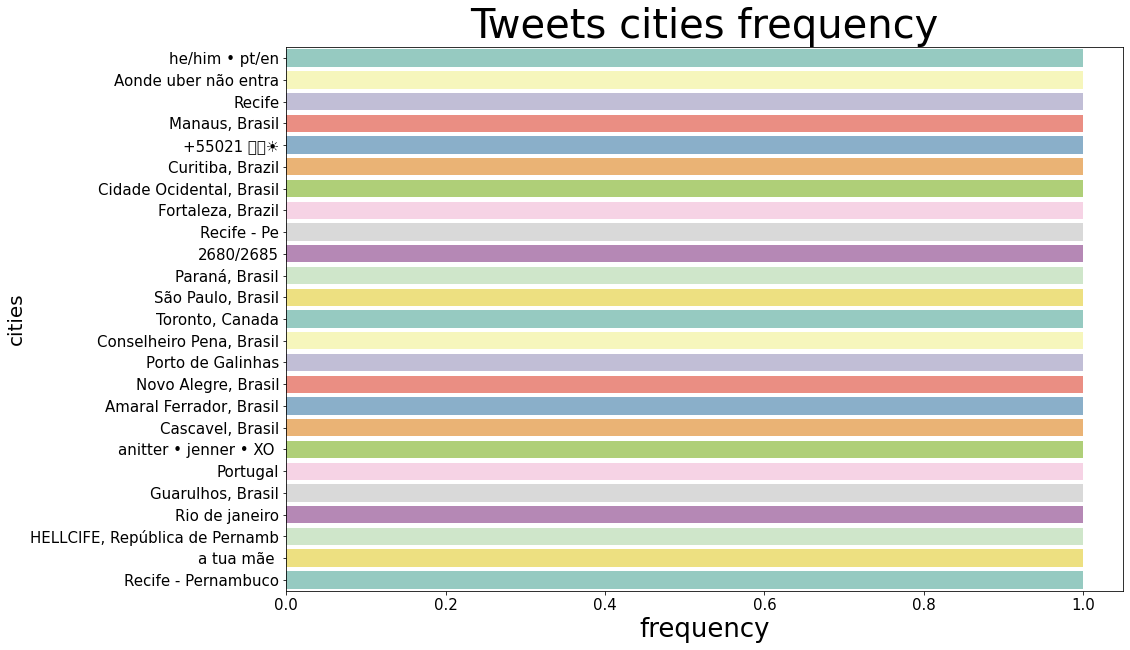

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig = plt.figure(figsize=(15,10))
fig.add_subplot(1,1,1)

df2 = df[:25]

ax = sns.barplot(y='city', x = 'frequency', data=df2, palette="Set3" )
ax.set(xlabel='Tweets cities frequency', ylabel='cities')
ax.axes.set_title("Tweets cities frequency",fontsize=40)
ax.set_xlabel("frequency",fontsize=26)
ax.set_ylabel("cities",fontsize=20)
ax.tick_params(labelsize=15)
#sns.plt.show()
plt.show()

## Capturar tweets com coodenadas de lat, long para cidade

In [30]:
def captura_tweets_com_coordenadas(tweets):
    tweets_com_coordenadas = []
    for tweet in tweets:
        if tweet['place'] is not None:
            tweets_com_coordenadas.append(tweet)
    return (tweets_com_coordenadas)

In [31]:
tweets_com_coordenadas = captura_tweets_com_coordenadas(results)
print(len(tweets_com_coordenadas))

3


In [32]:
len(tweets_com_coordenadas)/len(results) * 100

1.5

In [33]:
tweets_com_coordenadas[0]['place']['bounding_box']

{'type': 'Polygon',
 'coordinates': [[[-35.237951, -8.604637],
   [-34.946089, -8.604637],
   [-34.946089, -8.310038],
   [-35.237951, -8.310038]]]}

In [34]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates']

[[[-35.237951, -8.604637],
  [-34.946089, -8.604637],
  [-34.946089, -8.310038],
  [-35.237951, -8.310038]]]

In [35]:
tweets_com_coordenadas[0]['place']['bounding_box']['coordinates'][0][0]

[-35.237951, -8.604637]

In [36]:
def captura_coordenadas(tweets):
    coordenadas = []
    for tweet in tweets:
        coord = tweet['place']['bounding_box']['coordinates'][0][0]
        coordenadas.append(coord)
    return coordenadas

In [37]:
tweets_coordenadasXY = captura_coordenadas(tweets_com_coordenadas)
tweets_coordenadasXY[:5]

[[-35.237951, -8.604637], [-46.826039, -24.008814], [-35.019805, -8.157554]]

In [38]:
len(tweets_com_coordenadas)

3

In [39]:
latitudes_tweets =  [ y for x,y in tweets_coordenadasXY]
longitudes_tweets =  [ x for x,y in tweets_coordenadasXY]

In [40]:
coordenadas_distintas = set(latitudes_tweets)
len(coordenadas_distintas)

3

In [41]:
print(list(latitudes_tweets[:15]))

[-8.604637, -24.008814, -8.157554]


In [42]:
print(list(longitudes_tweets[:15]))

[-35.237951, -46.826039, -35.019805]


In [43]:
import pandas as pd
df10 = pd.DataFrame({'latitude': latitudes_tweets, 'longitude':longitudes_tweets })
df10.head()                   

,latitude,longitude
0,-8.604637,-35.237951
1,-24.008814,-46.826039
2,-8.157554,-35.019805


In [44]:
len(df10)

3

In [45]:
df11 = df10.drop_duplicates()
df11 = df11.reset_index(drop=True)
len(df11)

3

In [46]:
df11.to_csv('coordenadas-tweets-Novembro-2019.csv', index=False)

In [47]:
import pandas as pd
df11 = pd.read_csv('coordenadas-tweets-Novembro-2019.csv')
df11.head()

,latitude,longitude
0,-8.604637,-35.237951
1,-24.008814,-46.826039
2,-8.157554,-35.019805


In [48]:
for i in range(len(df11)):
    #print(i)
    row = df11.loc[i]
    #print(row)
    print('latitude:', row['latitude'], ', longitude:', row['longitude'] )

latitude: -8.604637 , longitude: -35.237951
latitude: -24.008814 , longitude: -46.826039
latitude: -8.157554 , longitude: -35.019805


In [49]:
print(list(latitudes_tweets[:10]))

[-8.604637, -24.008814, -8.157554]


In [50]:
print(list(longitudes_tweets[:10]))

[-35.237951, -46.826039, -35.019805]


## ler coordenadas de um arquivo

In [51]:
df10 = pd.read_csv('coordenadas-tweets-Novembro-2019.csv')
df10.head()

,latitude,longitude
0,-8.604637,-35.237951
1,-24.008814,-46.826039
2,-8.157554,-35.019805


In [52]:
df12 = df10.copy()
df12.head()
df12 = df12.dropna()
len(df12)
df12.head()

,latitude,longitude
0,-8.604637,-35.237951
1,-24.008814,-46.826039
2,-8.157554,-35.019805


## remover tuplas duplicadas

In [53]:
df13 = df12.drop_duplicates()
df13 = df13.reset_index(drop=True)
len(df13)

3

# Georeferenciar os tweets no mapa mundi

In [ ]:
#!pip install folium

In [54]:
import folium
from folium.utilities import write_png

mapit = folium.Map(location=[30, 0], zoom_start=2)
for coord in tweets_coordenadasXY:
    folium.CircleMarker( location=[ coord[1], coord[0] ], radius=2).add_to( mapit ) 
                    # color='#0080bb', fill_color='#0080bb'

#png_str = write_png(mapit. .data())
#of = open('folium_map.png', 'w')
#of.write(png_str)
#of.close()

folium.Map.save(mapit, "index.html")
#import os
#cmd = 'cutycapt --url=file:///index.html --out=folium_map.png'
#os.system(cmd)

mapit

# twitter trends - assuntos mais comentados do momento

In [ ]:
import json
import twitter

# Acessar os tends da localidade
#http://woeid.rosselliot.co.nz/


def twitter_trends(twitter_api, woe_id):
    # Prefix ID with the underscore for query string parameterization.
    # Without the underscore, the twitter package appends the ID value
    # to the URL itself as a special-case keyword argument.
    return twitter_api.trends.place(_id=woe_id)

# Sample usage

twitter_api = oauth_login()

# See https://dev.twitter.com/docs/api/1.1/get/trends/place and
# http://developer.yahoo.com/geo/geoplanet/ for details on
# Yahoo! Where On Earth ID

WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
#print json.dumps(world_trends, indent=1)

US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
#print (json.dumps(us_trends, indent=1))
#us_trends[0]

#for trend in us_trends:
#    print (trend['as_of']['name'])

In [ ]:
def find_trends(country_trends):
    trends = country_trends[0]['trends']
    for trend in trends:
        print (trend['name'])

In [ ]:
from datetime import datetime
WORLD_WOE_ID = 1
world_trends = twitter_trends(twitter_api, WORLD_WOE_ID)
print ("topicos mais comentados: Mundo", datetime.now())
find_trends(world_trends)

In [ ]:
US_WOE_ID = 23424977
us_trends = twitter_trends(twitter_api, US_WOE_ID)
print ("topicos mais comentados: USA", datetime.now())
find_trends(us_trends)

In [ ]:
BR_WOE_ID = 23424768
br_trends = twitter_trends(twitter_api, BR_WOE_ID)
print ("topicos mais comentados: Brasil", datetime.now())
find_trends(br_trends)

In [ ]:
TM_WOE_ID = 32566
tm_trends = twitter_trends(twitter_api, TM_WOE_ID)
print ("topicos mais comentados: UK")
find_trends(tm_trends)

In [ ]:
TM_WOE_ID = 455827
tm_trends = twitter_trends(twitter_api, TM_WOE_ID)
print ("topicos mais comentados: São Paulo")
find_trends(tm_trends)

# Análise de Sentimentos - Tweets

In [ ]:
#!pip install textblob

In [ ]:
#!pip install googletrans

In [ ]:
from googletrans import Translator
translator = Translator()
translator.translate('oi, tudo bem', src='pt').text

### Testando as polaridades

In [ ]:
from textblob import TextBlob as tb
txt = 'bad girl in NY'
analysis = tb(txt)
analysis.sentiment.polarity
analysis.sentiment

In [ ]:
txt = 'neutral'
analysis = tb(txt)
analysis.sentiment.polarity

In [ ]:
txt = 'good'
analysis = tb(txt)
analysis.sentiment.polarity

In [ ]:
txt = 'péssimo'
tb_txt = tb(txt)
tb_txt.sentiment.polarity
txt = tb_txt.translate(to='en')
txt.sentiment.polarity

# polaridade de tweets em ingles e portugues

In [ ]:
from textblob import TextBlob as tb #NLP module
import numpy as np #for some calculation. You may want to use your favorite module for this, such as statistics

# polaridade de tweets em ingles e portugues
def polarity_tweets_pais(query):
    from googletrans import Translator
    
    translator = Translator() # google tradutor

    twitter_api = oauth_login()
    numero_iteracoes = 1
    results = []
    for i in range(numero_iteracoes):
        max_results = 500 # 1000
        result = twitter_search(twitter_api, query, max_results=max_results)
        print ('capturando ', len(result),' tweets...')
        #results.append(result)
        results += result

    analysis = None
    pos_polarity = 0
    neutral_polarity = 0
    neg_polarity = 0
    sum_polarity = 0
    print("calculando polaridades...")

    for tweet in results:
        text_tweet = tweet['text']
        
        # retirando caracteres malucos
        text_tweet = "".join([i for i in text_tweet if ord(i)<128])
        
        frase = tb(text_tweet)       
        language = tweet['lang'] #frase.detect_language()
        if language == 'br' or language == 'pt' :
            text_en = translator.translate(text_tweet, src='pt').text  
            analysis = tb(text_en)
        elif language == 'en':   
            analysis = frase
        else:
            analysis = ""
            
        if analysis != "": 
            if (analysis.sentiment.polarity > 0):
                pos_polarity += 1
            elif (analysis.sentiment.polarity <= 0):
                neg_polarity += 1
            sum_polarity += analysis.sentiment.polarity

    return sum_polarity, pos_polarity, neg_polarity, neutral_polarity

In [ ]:
q = 'tesla'

"""
mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
total = pos_polarity + neg_polarity + neutral_polarity 
print('SENTIMENT AVERAGE: ' , mean_polarity/total)
print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100
"""

In [ ]:
import pandas as pd
df = pd.DataFrame(columns=['name', 'pos', 'negative', 'sentiment_avg'])
queries = [ 'tesla', 'facebook', 'apple', 'xiaomi']

for q in queries:
    mean_polarity, pos_polarity, neg_polarity, neutral_polarity = polarity_tweets_pais(q)
    total = pos_polarity + neg_polarity + neutral_polarity 
    print('Query: ', q)
    print('SENTIMENT AVERAGE: ' , mean_polarity/total)
    print('Positive: ', pos_polarity, (pos_polarity/total) * 100)
    print('Negative: ', neg_polarity, (neg_polarity/total) * 100)
    #print('neutral: ', neutral_polarity, (neutral_polarity/total) * 100)
    print('----------------------------------------------')
    
    i = len(df)
    df.loc[i] = [q, pos_polarity, neg_polarity, mean_polarity/total]
df

In [ ]:
df["%pos"] = df.pos / (df.pos + df.negative)
df["%neg"] = df.negative / (df.pos + df.negative)
df["%pos"] = df["%pos"].apply(lambda x: int(round(x,1) * 100))
df["%neg"] = df["%neg"].apply(lambda x: int(round(x,1) * 100))
df.loc[:, ['name', "%pos", "%neg", 'sentiment_avg' ]]

### gravando os dados do dataframe num arquivo .csv

In [ ]:
from datetime import datetime
data_agora = str(datetime.now())
df.to_csv("sentimentos-"+ data_agora +".csv")

In [ ]:
df.loc[:, ['name', "%pos", "%neg" ]]